# Implementation of a 3D Unet Architecture


In [2]:
import numpy as np 
import matplotlib.pyplot as plt 
import os, time
from importlib import reload

# 3D visualization tools
from mayavi import mlab
mlab.init_notebook(backend='ipy')
#mlab.options.backend = 'envisage'
import tensorflow as tf
import model, utilities

Notebook initialized with ipy backend.


ModuleNotFoundError: No module named 'model'

In [2]:
# Import modules providing tools for image manipulation
import sys
sys.path.append('../tools/')
import mosaic, deformation, affine 

In [3]:
# Reload of custom libraries to test hot-fixes
reload(utilities)
reload(model)
reload(deformation)
reload(affine)

<module 'affine' from '../tools\\affine.py'>

In [3]:
# Fix for tensorflow-gpu issues that I found online... (don't ask me what it does)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


## Convolutional Network Arithmetics

### Graphics memory
While the architecture of the Unet is agnostic regarding the shape of it's 3D Input efficient evaluation demands constant input size.
The first call of the Unet model triggers the allocation of GPU memory. Beside the massive number of parameters, the 3D tensors itself have large memory requirements. The maximum input tensor size is therefore directly determined by the available graphics memory of the GPU.

The size of 220px^3 input cubes with 8 initial filters has been determined to lie close to the memory max of my personal computer (6 GB graphics memory)
On the Janelia desktop computer (12GB graphics memory) up to 300px^3 cubes can be used.

The voxel size of the single fru labeled neuron dataset is specified as roghly (0.1 um x 0.1 um x 0.18 um).
### Reduction of output size
Since the Unet architecture relies only on valid convolution operations, the size of the output tensor is reduced with respect to the input. The unet architecture requires an even tensor shape before every max pooling operation. This narrows down the permissible input sizes. utilities.check_size() performs the necessary calculations to check which input sizes are valid and what output dimensions result from them.

In [4]:
# Get permissible network input sized (cube lengths)
n_blocks = 2 # The number of downsample und upsample blocks in each branch of the network.
valid_inputs = [n for n in range(512) if utilities.check_size(n, n_blocks=n_blocks)[0]]
print(valid_inputs)
# Check ouput for a given input size
cube_length = 220
output_length = utilities.check_size(cube_length, n_blocks)[1]
print('Output shape at {} is {} (mask_crop = {})'.format(cube_length,output_length,
                                                        (cube_length-output_length)/2))

[92, 100, 108, 116, 124, 132, 140, 148, 156, 164, 172, 180, 188, 196, 204, 212, 220, 228, 236, 244, 252, 260, 268, 276, 284, 292, 300, 308, 316, 324, 332, 340, 348, 356, 364, 372, 380, 388, 396, 404, 412, 420, 428, 436, 444, 452, 460, 468, 476, 484, 492, 500, 508]
Output shape at 220 is 132.0 (mask_crop = 44.0)


## Data Input Pipeline

The whole dataset has a size in the order of terabytes. At this stage we only work with preextracted volumes of (220px)^3 size.
Heavy use of data augumentation should enable the network to learn efficiently from a very low number of annotated samples.

the utilities module offers a custom keras.util.Sequence object that performs real time data augumentation. At the moment these operations consume a lot of time and could take up a lot of additional time


In [5]:
# Load some slices from the dataset

# Locate the sample directory on the computer
base_dir = 'C:\\Users\\Linus Meienberg\\Documents\\ML Datasets\\FruSingleNeuron_20190707\\SampleCrops'
samples = os.listdir(base_dir)

# Load all sample training data
train_samples = [utilities.load_volume(os.path.join(base_dir, sample)) for sample in samples[:2]] # List of dicts
train_images = [sample['image'] for sample in train_samples] # List of image tensors
train_masks = [sample['mask'] for sample in train_samples] # List of mask tensors

# Load all sample test data
test_samples = [utilities.load_volume(os.path.join(base_dir, sample)) for sample in samples[2:]] # List of dicts
test_images = [sample['image'] for sample in test_samples] # List of image tensors
test_masks = [sample['mask'] for sample in test_samples] # List of mask tensors

In [10]:
#TODO explore techniques to speed up image augumentation and batch preparation
train_sequence = utilities.Dataset3D(batch_size=1, batches = 20, images=train_images, masks=train_masks, mask_crop=44, augument=True, elastic=True, affine=True)
test_sequence  = utilities.Dataset3D(batch_size=1, batches = 4, images=test_images, masks=test_masks, mask_crop=44, augument= True, elastic=False, affine=True)

## Visualization and augumentation tools

The following section is a quick demonstration of the 3D visualization and image augumentation tools provided by the utilities, affine and deformation module.

In [45]:
#Load the first sample as a test case
sample = utilities.load_volume(os.path.join(base_dir, samples[0])) # Dicttionary holding image and mask tensor
utilities.show3DImage(sample['image']) # Visualize image data using some isosurfaces

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01\xf4\x00\x00\x01\xf4\x08\x02\x00\x00\x00D\xb4H\xd…

In [46]:
utilities.show3DImage(sample['mask'], mode='mask') # Visualize mask data with slightly different parameters

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01\xf4\x00\x00\x01\xf4\x08\x02\x00\x00\x00D\xb4H\xd…

In [33]:
np.histogram(sample['mask'], bins=3)
#BUG The mask seems to contain integer values up to 3 how does that come? what does it signify? 

(array([28756806,  3184260,     2934], dtype=int64),
 array([0., 1., 2., 3.], dtype=float32))

In [71]:
# Illustrate the use of the elastic deformation tool implemented in the deformation module
displacement = deformation.displacementGridField3D((220,220,220), n_lines=5) # define a 3D vector field that is applied to the image coordinates
sample_img_deformed = deformation.applyDisplacementField3D(sample['image'], *displacement)
sample_mask_deformed = deformation.applyDisplacementField3D(sample['mask'], *displacement, interpolation_order= 0)

In [72]:
utilities.show3DImage(sample_img_deformed)

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01\xf4\x00\x00\x01\xf4\x08\x02\x00\x00\x00D\xb4H\xd…

In [24]:
# Directly visualize a tensor in the batch structure generated by utilities.Dataset3D
test_batch = train_sequence.__getitem__(0)
utilities.show3DImage(test_batch[1][0,...], mode='mask') 
utilities.showCutplanes(test_batch[0][0,44:177,44:177,44:177], newFigure=False) 

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01\xf4\x00\x00\x01\xf4\x08\x02\x00\x00\x00D\xb4H\xd…

In [22]:
s = mlab.contour3d(test_batch[0][0,...,0], color=(1,0,0))

In [37]:
pred.shape

TensorShape([1, 132, 132, 132, 2])

## Training the 3D Unet


In [46]:
reload(model)

<module 'model' from 'c:\\Users\\Linus Meienberg\\Google Drive\\Janelia\\ImageSegmentation\\3D Unet\\model.py'>

In [7]:
# Define the model (build is triggered on first call)
#unet = model.Unet(n_blocks=2, initial_filters=8)(inputs=tf.keras.layers.Input(shape=(220,220,220,1)))
unet = model.build_unet(input_shape=(220,220,220,1), n_blocks=2, initial_filters=2)
#test_batch = train_sequence.__getitem__(0)
#test_output = unet(test_batch[0])
#test_output.shape

In [8]:
unet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 220, 220, 22 0                                            
__________________________________________________________________________________________________
input_block (InputBlock)        ((None, 108, 108, 10 276         input_1[0][0]                    
__________________________________________________________________________________________________
downsample_block (DownsampleBlo ((None, 52, 52, 52,  1308        input_block[0][0]                
__________________________________________________________________________________________________
downsample_block_1 (DownsampleB ((None, 24, 24, 24,  5208        downsample_block[0][0]           
______________________________________________________________________________________________

In [9]:
# Calculate the ratio of neuron to background pixels in the training set so that we can adjust class weights
object_ratio = np.mean(np.stack(train_masks)) # mean = sum / tot_pixels = the proportion of class label 1
object_weight = 1 / object_ratio # devide by proportion of cases to factor out imbalance of case numbers
background_weight = 1 / (1-object_ratio)
print('class weights background (0) * {:.3f} objects (1) * {:.3f}'.format(background_weight, object_weight))# 

class weights background (0) * 1.101 objects (1) * 10.919


In [12]:
unet.compile(
    optimizer = tf.keras.optimizers.RMSprop(),
    loss = model.weighted_sparse_categorical_crossentropy(class_weights=[1,2.5])
             )

In [11]:
test_batch = train_sequence.__getitem__(0)
#unet.train_on_batch(x=test_batch[0], y=test_batch[1])
masks = test_batch[1]

In [13]:
history = unet.fit(train_sequence, epochs=30,
                   validation_data= test_sequence,
                   callbacks=[tf.keras.callbacks.ModelCheckpoint('3d_unet_0719.h5', save_best_only=True)])
                       

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 20 steps, validate for 4 steps
Epoch 1/30
20/20 [==============================] - 335s 17s/step - loss: 0.4415 - val_loss: 0.3632
Epoch 2/30
20/20 [==============================] - 331s 17s/step - loss: 0.4369 - val_loss: 0.3338
Epoch 3/30
20/20 [==============================] - 331s 17s/step - loss: 0.4706 - val_loss: 0.3177
Epoch 4/30
20/20 [==============================] - 330s 17s/step - loss: 0.3781 - val_loss: 0.2634
Epoch 5/30
20/20 [==============================] - 330s 17s/step - loss: 0.3062 - val_loss: 0.1367
Epoch 6/30
20/20 [==============================] - 330s 16s/step - loss: 0.3196 - val_loss: 0.2859
Epoch 7/30
20/20 [==============================] - 331s 17s/step - loss: 0.2758 - val_loss: 0.2624
Epoch 8/30
20/20 [==============================] - 331s 17s/step - loss: 0.2674 - val_loss: 0.1876
Epoch 9/30
20/20 [==============================] - 331s 17s/step - loss: 0.2393 - val_loss: 0.0470
Epoch 10/

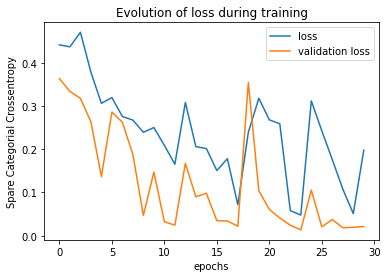

In [15]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss','validation loss'])
plt.title('Evolution of loss during training')
plt.xlabel('epochs')
plt.ylabel('Spare Categorial Crossentropy')
plt.savefig('3d_unet_0719.png')

In [43]:
# Restore the trained model. Specify where keras can find custom objects that were used to build the unet
unet = tf.keras.models.load_model('3d_unet_0717.h5',
                                        compile=False,
                                     custom_objects={    "InputBlock" : model.InputBlock,
                                                    "DownsampleBlock" : model.DownsampleBlock,
                                                    "BottleneckBlock" : model.BottleneckBlock,
                                                      "UpsampleBlock" : model.UpsampleBlock,
                                                        "OutputBlock" : model.OutputBlock})

In [44]:
unet.compile(optimizer='sgd', loss=model.weighted_sparse_categorical_crossentropy(class_weights=[background_weight,object_weight]))

In [16]:
# get sample predictions on the test data
test_batch = test_sequence.__getitem__(0)
sample_prediction = unet.predict(test_batch)
print(sample_prediction.shape)
sample_prediction_mask = utilities.segmentationMask(sample_prediction)

(1, 132, 132, 132, 2)


In [151]:
reload(utilities)

<module 'utilities' from 'c:\\Users\\Linus Meienberg\\Google Drive\\Janelia\\ImageSegmentation\\3D Unet\\utilities.py'>

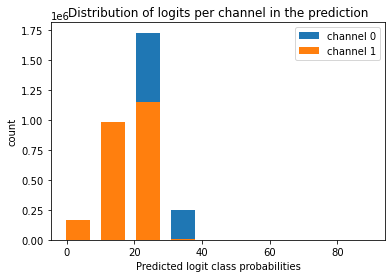

In [17]:
utilities.showLogitDistribution(sample_prediction)

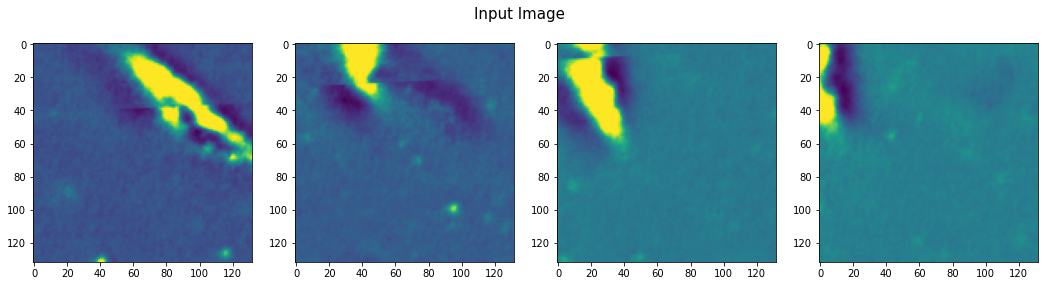

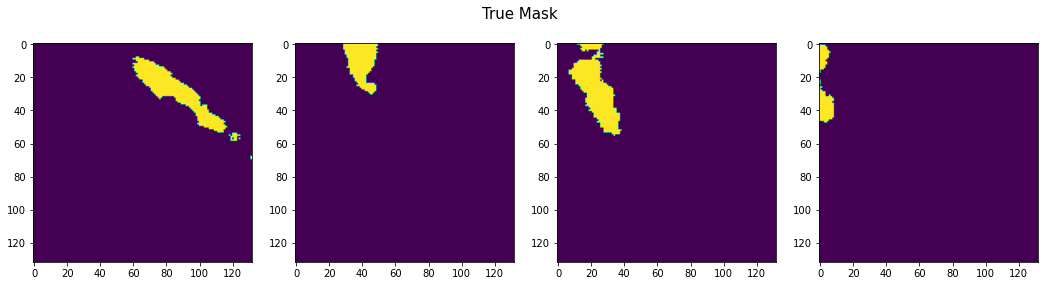

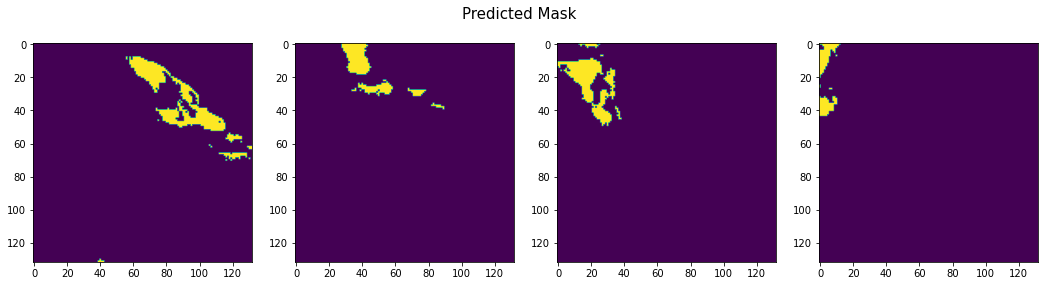

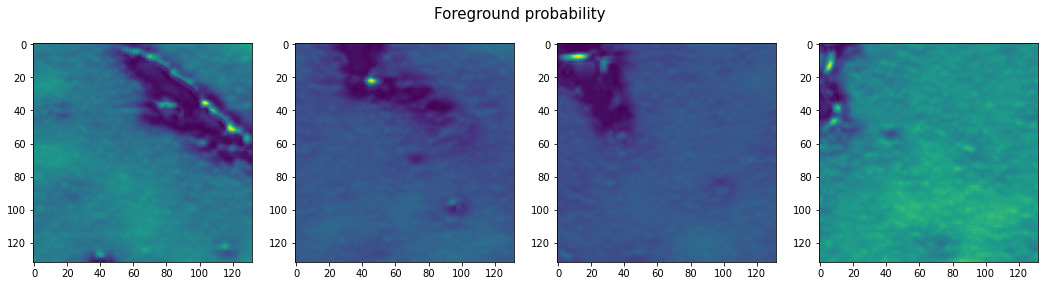

In [18]:
utilities.showZSlices(test_batch[0][0,44:176,44:176,44:176,:], channel=0, n_slices=4, title='Input Image')
utilities.showZSlices(test_batch[1][0], channel=0, n_slices=4, title='True Mask')
utilities.showZSlices(sample_prediction_mask[0], channel=0, title='Predicted Mask')
utilities.showZSlices(sample_prediction[0], channel=1, title='Foreground probability')

In [1]:
utilities.show3DImage(test_batch[0][0,44:176,44:176,44:176,:])
utilities.showCutplanes(sample_prediction_mask[0,...], newFigure=False, hint=True)

NameError: name 'utilities' is not defined

In [22]:
utilities.show3DImage(sample_prediction_mask[0,...], mode='mask')

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01\xf4\x00\x00\x01\xf4\x08\x02\x00\x00\x00D\xb4H\xd…